In [2]:
%reload_ext autoreload
%autoreload 2

for EVs, most variable power charging curves are expressed with the x-axis being "state of charge"
i.e. what percentage of full the battery is currently at.

e.g. see the image here https://www.researchgate.net/figure/EV-charging-curves-at-300-kW-chargers-35_fig1_368980942

In [181]:
# encode the variable power curves
from dataclasses import dataclass
import pandas as pd

@dataclass
class Battery:
    capacity_kWh: float
    charging_curve: pd.DataFrame # columns SoC and kW
    initial_soc: float = 0.2

    def plot_changing_curve(self):
        self.charging_curve.set_index("SoC").plot(
            grid=True,
            figsize=(4, 2),
            ylabel="kW",
            legend=False,
            title=f"battery capacity {self.capacity_kWh} kWh"
        )

    def get_usage_power_kw_df(self):
        """
        Output the variable charging curve in the format that optimizer accepts.
        That is, dataframe with index "time" in minutes and "power_kw" which
        tells us the average power consumption in a five minute interval
        after an elapsed amount of time of charging.
        """
        capacity_kWh = self.capacity_kWh
        initial_soc = self.initial_soc
        charging_curve = self.charging_curve

        def get_kW_at_SoC(df, soc):
            """Linear interpolation to get charging rate at any SoC"""
            prev_row = df[df["SoC"]< soc].iloc[-1]
            next_row = df[df["SoC"] >= soc].iloc[0]
            m1 = prev_row["SoC"]
            p1 = prev_row["kW"]
            m2 = next_row["SoC"]
            p2 = next_row["kW"]
            return p1 + (soc - m1) / (m2 - m1) * (p2 - p1)

        # iterate over seconds
        result = []
        secs_elapsed = 0
        charged_kWh = capacity_kWh * initial_soc
        kW_by_second = []
        while charged_kWh < capacity_kWh:
            secs_elapsed += 1
            curr_soc = charged_kWh / capacity_kWh
            curr_kW = get_kW_at_SoC(charging_curve, curr_soc)
            kW_by_second.append(curr_kW)
            charged_kWh += curr_kW / 3600

            if secs_elapsed % 300 == 0:
                result.append((int(secs_elapsed / 60 - 5), pd.Series(kW_by_second).mean()))
                kW_by_second = []

        return pd.DataFrame(columns=["time", "power_kw"], data=result)

In [182]:
# https://insideevs.com/news/613786/chevrolet-bolt-ev-fast-charging/
chevy_bolt = Battery(
    capacity_kWh=65.0,
    charging_curve = pd.DataFrame(
        columns=["SoC", "kW"],
        data = [
            [0.0, 50.0],
            [0.5, 50.0],
            [0.93, 20.0],
            [1.0, 0.5],
        ]
    ),
)

# https://insideevs.com/news/519382/tesla-model3-82kwh-charging-analysis/
tesla_model_3 = Battery(
    capacity_kWh=82.0,
    charging_curve = pd.DataFrame(
        columns=["SoC", "kW"],
        data = [
            [0.0, 250.0],
            [0.15, 250.0],
            [0.5, 90.0],
            [1.0, 10.0],
        ]
    ),
)

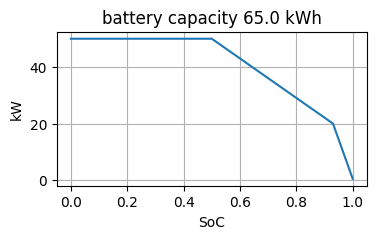

In [183]:
chevy_bolt.plot_changing_curve()

In [184]:
usage_power_kw_df = chevy_bolt.get_usage_power_kw_df()

In [185]:
usage_power_kw_df

,time,power_kw
0,0,50.000000
1,5,50.000000
2,10,50.000000
3,15,50.000000
4,20,49.775507
5,25,46.485914
6,30,42.507926
7,35,38.870351
8,40,35.544058
9,45,32.502410


In [187]:
import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import data.s3 as s3u
import evaluation.eval_framework as efu

import time
from datetime import date, datetime, timedelta

import pandas as pd
from dateutil.parser import parse
from pytz import UTC, timezone
import matplotlib.pyplot as plt

from watttime import (
    WattTimeMyAccess,
    WattTimeHistorical,
    WattTimeForecast,
    WattTimeOptimizer,
)

region = "PJM_NJ"
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

wt_opt = WattTimeOptimizer(username, password)

now = datetime.now(UTC)
window_start_test = now + timedelta(minutes=10)
window_end_test = now + timedelta(minutes=720)

dp_usage_plan= wt_opt.get_optimal_usage_plan(
    region=region,
    usage_window_start=window_start_test,
    usage_window_end=window_end_test,
    usage_time_required_minutes=320,
    usage_power_kw=usage_power_kw_df,
    optimization_method="auto",
)

== Sophisticated fit! ==


<Axes: xlabel='point_time'>

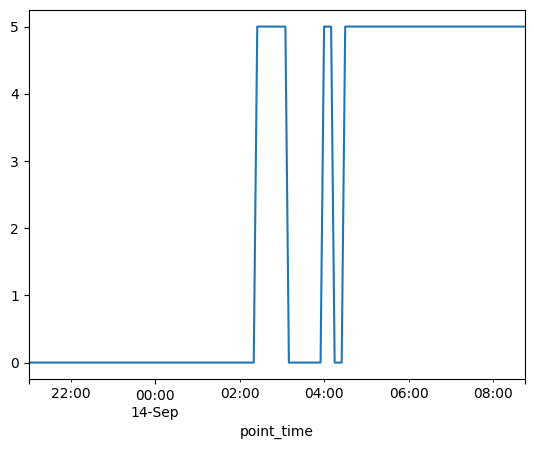

In [191]:
dp_usage_plan["usage"].plot()